In [1]:
import numpy as np
import pandas as pd
import math as math
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics, linear_model, neighbors, neural_network, tree, ensemble, gaussian_process, naive_bayes
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import accuracy_score, recall_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from time import time

df = pd.read_csv('../data.csv')
print(df.shape)
print()
print(df.columns)
print()
#print(df.head)
#print()
print(df.dtypes)
print()
#print(df.describe())
#print()
print(df.isnull().any().any())
df.iloc[:,1024].value_counts().sort_index()

(92000, 1025)

Index(['pixel_0000', 'pixel_0001', 'pixel_0002', 'pixel_0003', 'pixel_0004',
       'pixel_0005', 'pixel_0006', 'pixel_0007', 'pixel_0008', 'pixel_0009',
       ...
       'pixel_1015', 'pixel_1016', 'pixel_1017', 'pixel_1018', 'pixel_1019',
       'pixel_1020', 'pixel_1021', 'pixel_1022', 'pixel_1023', 'character'],
      dtype='object', length=1025)

pixel_0000     int64
pixel_0001     int64
pixel_0002     int64
pixel_0003     int64
pixel_0004     int64
               ...  
pixel_1020     int64
pixel_1021     int64
pixel_1022     int64
pixel_1023     int64
character     object
Length: 1025, dtype: object

False


character_01_ka              2000
character_02_kha             2000
character_03_ga              2000
character_04_gha             2000
character_05_kna             2000
character_06_cha             2000
character_07_chha            2000
character_08_ja              2000
character_09_jha             2000
character_10_yna             2000
character_11_taamatar        2000
character_12_thaa            2000
character_13_daa             2000
character_14_dhaa            2000
character_15_adna            2000
character_16_tabala          2000
character_17_tha             2000
character_18_da              2000
character_19_dha             2000
character_20_na              2000
character_21_pa              2000
character_22_pha             2000
character_23_ba              2000
character_24_bha             2000
character_25_ma              2000
character_26_yaw             2000
character_27_ra              2000
character_28_la              2000
character_29_waw             2000
character_30_m

### Scaling and separation of data and labels

Quite a few classification algorithms will only work on scaled and normalized features. 0 to 255 is a huge range, and given the nature of the characters (visible in the rendered samples further along in this notebook) a large majority of the features in every sample will read 0. So scaling the range 0 to 255 to 0 to 1 would help.

We will also create two arrays now. One array will be the images themselves, and the other array will be the class labels (based on rough transliterations of the characters into English language/Latin script).

In [2]:
character_images = df.iloc[:,:-1]
#character_images
print(character_images.shape)
print()
character_images = character_images.astype("float64")
character_images /= 255

character_names = df.iloc[:,-1]
print(character_names)
num_characters = len(character_names.unique())
num_characters

(92000, 1024)

0        character_01_ka
1        character_01_ka
2        character_01_ka
3        character_01_ka
4        character_01_ka
              ...       
91995            digit_9
91996            digit_9
91997            digit_9
91998            digit_9
91999            digit_9
Name: character, Length: 92000, dtype: object


46

### Reshaping to view the actual characters

The classification algorithms themselves will work on 1-D feature vectors. However, we reshape the pixel arrays here so as to be able to visualize a sample of each of the 46 character classes. It gives us a good sense of the accuracy when looking at the predicted sample of images of each of the various algorithms. It will also help in visualizing how various classification algorithms might fare given the peculiarities of these feature arrays.

In [3]:
w = h = math.sqrt(character_images.shape[1])
images = character_images.values.reshape(character_images.shape[0], int(w), int(h))
images

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.19215686, ..., 0.56078431,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.10980392, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.08235294,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.25098039, ..., 0.        ,
         0.        , 0.        ],
        [0. 

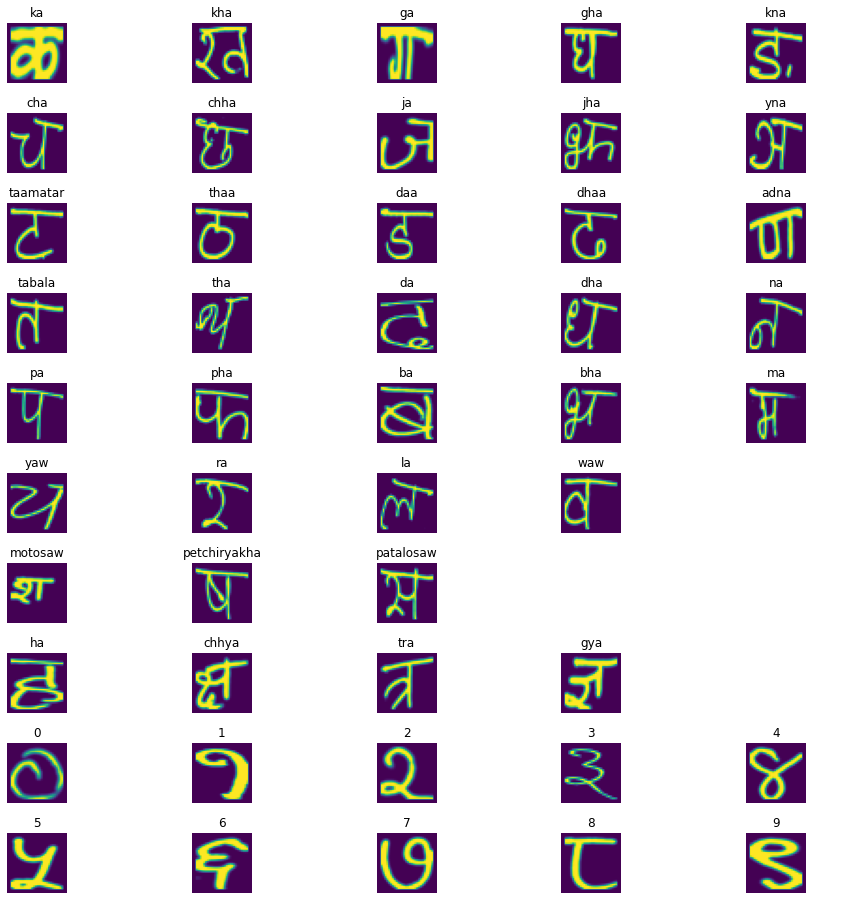

In [4]:
row_lengths = [5, 5, 5, 5, 5, 4, 3, 4, 5, 5]
character_count = 0

fig, ax = plt.subplots(10, 5, figsize=(16, 16))
for row in range(10):
    for col in range(5):
        ax[row, col].set_axis_off()
        if col < row_lengths[row]:
            if 2000*(character_count) < 92000:
                ax[row, col].imshow(images[2000*character_count])
                ax[row, col].set_title(character_names[2000*character_count].split("_")[-1])
                character_count += 1

plt.subplots_adjust(hspace=0.5)

## Analysis and machine learning

### Creating a second data set

kNN and SVM are considered to be very good ML classification algorithms for use with character recognition. However, 92000 data samples and 1024 features per sample would probably mean these algorithms took forever to run on my home PC's 4 hyper-threaded cores running only at 4.2 Ghz, and 32 GBs of RAM.

So we will use principal component analysis to reduce the number of features while retaining 99% of the variance.

Doing so reduces the size of the feature vector from 1024 to 403.

Going down to 95% variance will reduce it further to only ~175 features, but ~400 is comfortable. In fact, the Gaussian Process classifier couldn't run without a MemoryError even with a 175-dimension feature vector.

The only problem is that some of the Naive Bayes classifiers, such as ComplementNB, CategoricalNB and Multinomial NB, will stop working because they don't accept negative values in the features. It could also be that there is a way here, but I have not researched this.

In [5]:
test_pca_model = PCA(n_components=0.99, svd_solver='full')
pca_reduced_images = test_pca_model.fit_transform(character_images)
#test_pca_model.get_params()
#test_pca_model.explained_variance_ratio_.cumsum()
pca_reduced_images.shape

(92000, 403)

In [6]:
classifiers = [
#    ('SVM', False, False, OneVsOneClassifier(svm.SVC(decision_function_shape='ovo', random_state=42), n_jobs=-1), False, False, False),
#    ('k-Nearest Neighbours', False, False, OneVsRestClassifier(neighbors.KNeighborsClassifier(n_neighbors=3), n_jobs=-1), False, False, False),
#    ('Nearest Centroid', False, False, OneVsRestClassifier(neighbors.NearestCentroid(), n_jobs=-1), False, False, False),
#    ('Gaussian Process', False, False, OneVsRestClassifier(gaussian_process.GaussianProcessClassifier(copy_X_train=False, random_state=42), n_jobs=-1), False, False, False),
#    ('Complement Naive Bayes', True, False, OneVsRestClassifier(naive_bayes.ComplementNB(), n_jobs=-1), True, True, True),
#    ('Categorical Naive Bayes', True, False, OneVsRestClassifier(naive_bayes.CategoricalNB(), n_jobs=-1), True, True, True),
#    ('Multinomial Naive Bayes', True, False, OneVsRestClassifier(naive_bayes.MultinomialNB(), n_jobs=-1), True, True, True),
    ('Logistic Regression', True, True, OneVsRestClassifier(linear_model.LogisticRegression(multi_class='ovr', solver='saga', random_state=42), n_jobs=-1), True, True, True),
    ('Ridge', True, True, OneVsRestClassifier(linear_model.RidgeClassifier(random_state=42), n_jobs=-1), True, True, True),
    ('Linear SVM', True, True, OneVsRestClassifier(svm.LinearSVC(random_state=42), n_jobs=-1), True, True, True),
    ('Stochastic Gradient Descent', True, True, OneVsRestClassifier(linear_model.SGDClassifier(random_state=42), n_jobs=-1), True, True, True),
    ('Gaussian Naive Bayes', True, True, OneVsRestClassifier(naive_bayes.GaussianNB(), n_jobs=-1), True, True, True),
    ('Bernoulli Naive Bayes', True, True, OneVsRestClassifier(naive_bayes.BernoulliNB(), n_jobs=-1), True, True, True),
    ('Decision Tree', True, True, OneVsRestClassifier(tree.DecisionTreeClassifier(random_state=42), n_jobs=-1), True, True, True),
    ('Random Forest', True, True, OneVsRestClassifier(ensemble.RandomForestClassifier(random_state=42), n_jobs=-1), True, True, True),
    ('Perceptron', True, True, linear_model.Perceptron(random_state=42, n_jobs=-1), True, True, True),
    ('Passive Aggressive', True, True, linear_model.PassiveAggressiveClassifier(random_state=42, n_jobs=-1), True, True, True),
    ('Multi-level Perceptron', True, True, OneVsRestClassifier(neural_network.MLPClassifier(hidden_layer_sizes=(15, ), random_state=42), n_jobs=-1), True, True, True)
]

results = []

### Run!

Split the two datasets into train/test sets.

Set up global feature flags for the Booleans in the classifier tuples.

Execute the estimators, observe plots and observe/gather metrics for later comparison.

Logistic Regression
Calling Logistic Regression on full dimension data set


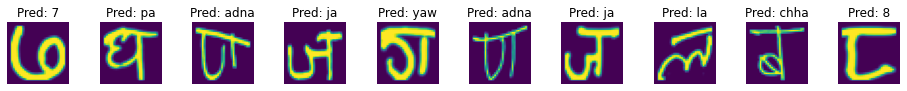

Calling Logistic Regression on reduced dimension data set


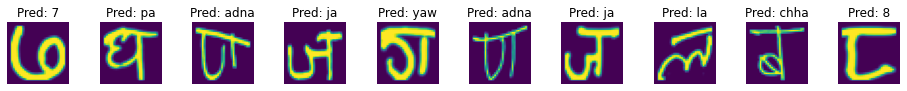


Ridge
Calling Ridge on full dimension data set


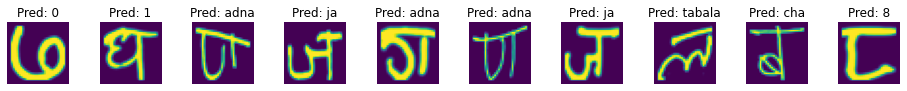

Calling Ridge on reduced dimension data set


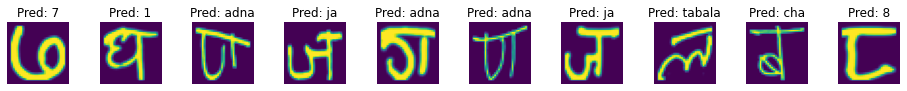


Linear SVM
Calling Linear SVM on full dimension data set


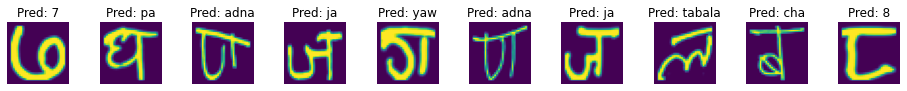

Calling Linear SVM on reduced dimension data set


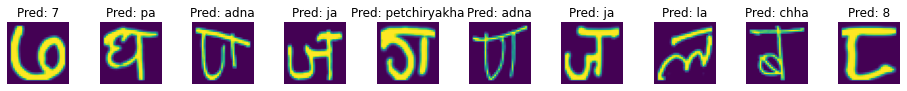


Stochastic Gradient Descent
Calling Stochastic Gradient Descent on full dimension data set


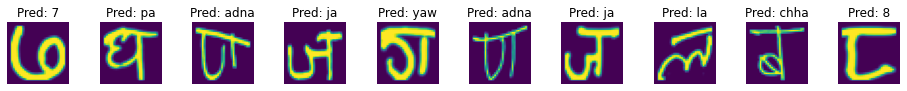

Calling Stochastic Gradient Descent on reduced dimension data set


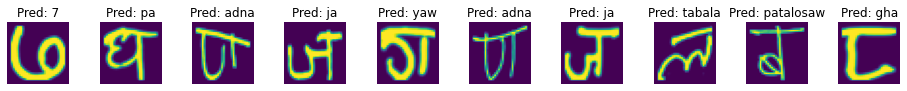


Gaussian Naive Bayes
Calling Gaussian Naive Bayes on full dimension data set


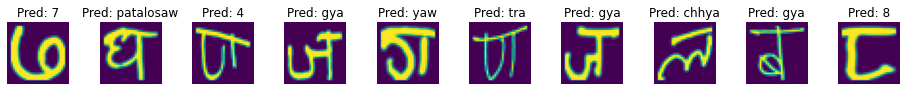

Calling Gaussian Naive Bayes on reduced dimension data set


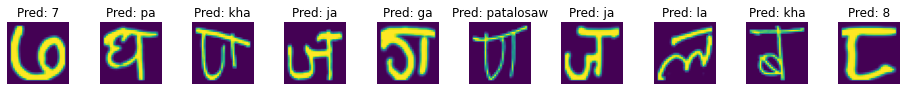


Bernoulli Naive Bayes
Calling Bernoulli Naive Bayes on full dimension data set


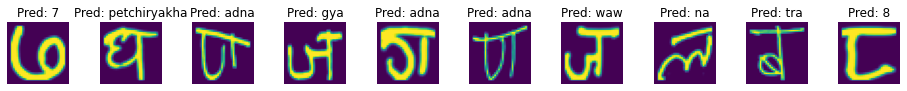

Calling Bernoulli Naive Bayes on reduced dimension data set


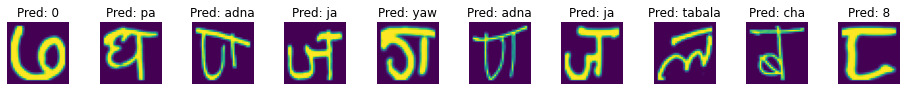


Decision Tree
Calling Decision Tree on full dimension data set


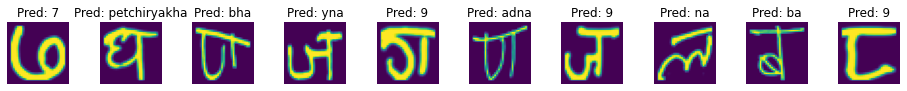

Calling Decision Tree on reduced dimension data set


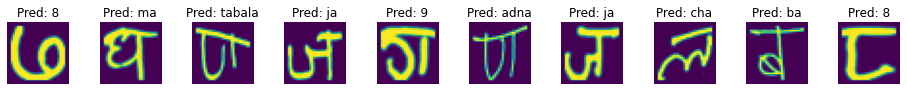


Random Forest
Calling Random Forest on full dimension data set


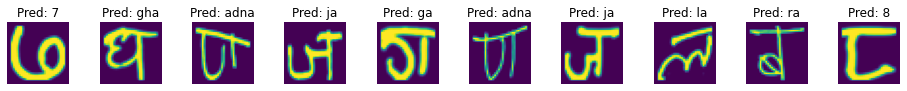

Calling Random Forest on reduced dimension data set


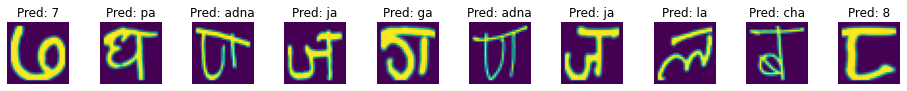


Perceptron
Calling Perceptron on full dimension data set


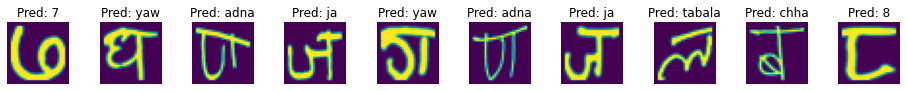

Calling Perceptron on reduced dimension data set


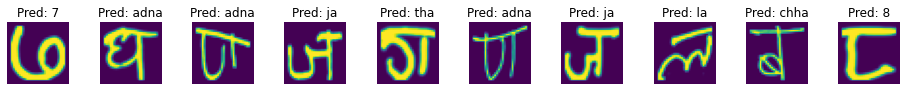


Passive Aggressive
Calling Passive Aggressive on full dimension data set


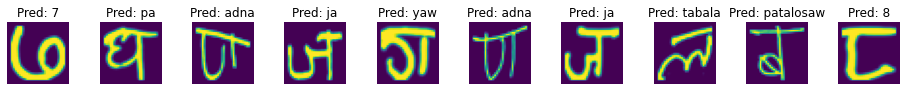

Calling Passive Aggressive on reduced dimension data set


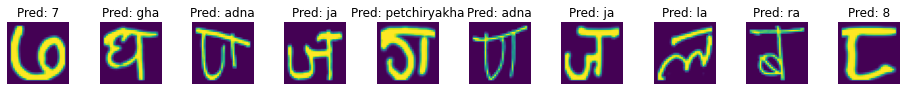


Multi-level Perceptron
Calling Multi-level Perceptron on full dimension data set


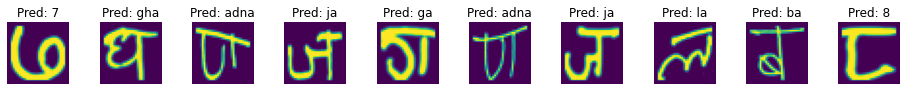

Calling Multi-level Perceptron on reduced dimension data set


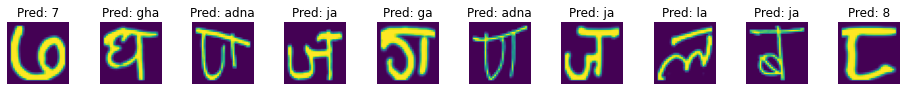

In [7]:
X_train, X_test, y_train, y_test = train_test_split(character_images, df.character, test_size=0.2, random_state=42, shuffle=True)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(pca_reduced_images, df.character, test_size=0.2, random_state=42, shuffle=True)

f_global = True
r_global = True
plot_cm_global = False
print_report_global = False
plot_samples_global = True

def run_and_gather(estimator, X_train, y_train, X_test, y_test, plot_cm=False, print_report=False, plot_samples=False):
    start = time()
    estimator.fit(X_train, y_train)
    mid = time()
    predicted = estimator.predict(X_test)
    end = time()
    
    if plot_samples:
        images_and_predictions = list(zip(images[y_test.index], predicted))
        fig, ax = plt.subplots(1, 10, figsize=(16, 16))
        for axis, (image, prediction) in zip(ax[:], images_and_predictions[13000:13010]):
            axis.set_axis_off()
            axis.imshow(image)
            axis.set_title('Pred: %s' % prediction.split("_")[-1])

        plt.subplots_adjust(wspace=0.5)
        
        plt.show()

    if print_report:
        print("Classification report for classifier %s:\n%s\n"
          % (estimator, metrics.classification_report(y_test, predicted)))

    if plot_cm:
        disp = metrics.plot_confusion_matrix(estimator, X_test, y_test)
#        print("Confusion matrix:\n%s" % disp.confusion_matrix)
        disp.figure_.set_size_inches(16, 16)
        plt.xticks(rotation=75)
        plt.subplots_adjust(left=-2)

        plt.show()

    return accuracy_score(y_test, predicted), mid - start, end - mid

def orchestrate(classifiers):
    for name, f_feas, r_feas, clf, plot_cm, print_report, plot_samples in classifiers:
        lst = [name]
        print(name)
        clf_f = clf
        clf_r = clf
    
        retval_f = []
        retval_r = []

        if plot_cm_global == False:
            plot_cm = False
        
        if print_report_global == False:
            print_report = False
        
        if plot_samples_global == False:
            plot_samples = False

        if (f_global & f_feas):
            print("Calling %s on full dimension data set" % (name))
            retval_f = run_and_gather(clf_f, X_train, y_train, X_test, y_test, plot_cm, print_report, plot_samples)
        else:
            print("Skipping %s on full dimension data set" % (name))
            retval_f = [0.0, 0.0, 0.0]
        lst.extend(retval_f)

        if (r_global & r_feas):
            print("Calling %s on reduced dimension data set" % (name))
            retval_r = run_and_gather(clf_r, Xr_train, yr_train, Xr_test, yr_test, plot_cm, print_report, plot_samples)
        else:
            print("Skipping %s on reduced dimension data set" % (name))
            retval_r = [0.0, 0.0, 0.0]
        lst.extend(retval_r)
        results.append(lst)
    #    print(lst)
        print()

orchestrate(classifiers)
#print(results)

## Voting Classifers

### Setup

[Quoting the scikit-learn User Guide](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier) -

*The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.*

This seemed very interesting.

So here we gather the accuracy scores of the estimators above for each of the data sets, and pick out only those estimators that give out accuracy scores in a certain range.

The high-level algorithm is as follows -

* Extract accuracy scores by dataset (1024 features and 403 features)
* Explore the series and run k-Means
    * Empirically, 6 clusters were observed on visualizing the accuracy scores for classifiers run on 1024 features
    * And 7 clusters (1 cluster for '0' scores) for classifiers run on 403 features
* Identify classifiers based on cluster labels and group them into different voting configurations
* Create a tuple for each voting configuration and add it to the list of 'voting_classifiers'
* Run the 'orchestrate' function on this list of voting classifiers

Other groupings may also be made. For example, mean() +/- <some_float>\*std(), or using the intuition from a boxplot (either IQR or the 'inter-whisker region'.

The results are interesting. The VotingClassifier gives us a small but noticeable boost in accuracy over the individual estimators.

It needs to be understood how the specific kNN-SVM implementation that comes up later in this notebook could be used a unified/single estimator to be given to VotingClassifier.

In [8]:
voting_classifiers = []

def get_series(results, dataset_type):
    selector = -1
    
    if dataset_type == 'full':
        selector = 1
    elif dataset_type == 'reduced':
        selector = 4
    else:
        return False

    dist = pd.Series([result[selector] for result in results])

    return dist

def create_voting_classifiers(dist, dataset_type, num_clusters):
    series_df = pd.DataFrame(dist)
    model = KMeans(init='k-means++', n_clusters=num_clusters, n_init=20).fit(series_df)

    dct = {'acc': np.array(dist), 'cluster_labels': model.labels_}
    f_df = pd.DataFrame(data=dct, index=[f_clf[0] for f_clf in classifiers])
    f_df = f_df[f_df['acc'] > 0]
    interim_series = f_df['cluster_labels'].value_counts() > 1
    interim_series = (interim_series[interim_series == True]).keys()

    for idx in interim_series:
        new_voting_classifier = []

        # tuple[0]
        name = 'Voting_' + dataset_type[0] + '_' + str(idx)
        new_voting_classifier.append(name)
        
        # tuple[1] and tuple[2]
        if dataset_type == 'full':
            new_voting_classifier.extend([True, False])
        elif dataset_type == 'reduced':
            new_voting_classifier.extend([False, True])
        else:
            new_voting_classifier.extend([False, False])

        # tuple[3]
        lst = f_df.index[f_df['cluster_labels'] == idx].tolist()
        select_list = [(tup[0], tup[3]) for tup in classifiers if tup[0] in lst]
        new_voting_classifier.append(ensemble.VotingClassifier(estimators=select_list, n_jobs=-1))

        # remaining tuples
        new_voting_classifier.extend([True, True, True])

        voting_classifiers.append(tuple(new_voting_classifier))

f_series = get_series(results, 'full')
r_series = get_series(results, 'reduced')

### How many clusters?

Perform simple visualizations of the accuracy values for each dataset to get a sense of the number of clusters required.

This is quite subjective. Anywhere between 4 and 6 clusters is perhaps justifiable given these numbers.

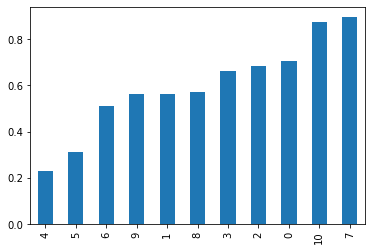

In [9]:
f_series.sort_values().plot(kind='bar')

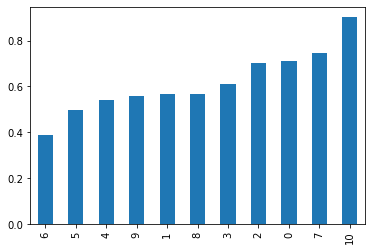

In [10]:
r_series.sort_values().plot(kind='bar')

### Now prepare the classifiers

In [11]:
create_voting_classifiers(f_series, 'full', 5)
create_voting_classifiers(r_series, 'reduced', 4)

### Go vote!

It needs to be seen if initializing the VotingClassifiers with pre-trained estimators can help reduce total time.

In [12]:
#orchestrate(voting_classifiers)
#print(results)
#print()

### kNN-SVM

While researching ML classifiers for handwritten character recognition, I came across [this insightful blog post](https://medium.com/the-andela-way/applying-machine-learning-to-recognize-handwritten-characters-babcd4b8d705) and decided to adapt [its implementation](https://github.com/briceicle/capstone/blob/master/model.py) for this notebook.

This is the best performing classifier. Also, I followed the advice in the article and didn't run it on the 1024-dimension data set.

As you can observe from the code below, it wouldn't have fit into the simple loop-over-classifier-tuple-configuration approach above. I didn't bother refactoring this code to make it fit the earlier structure as much as possible, because I felt it wouldn't have improved readability drastically.

It would be interesting to see the performance of SVC standalone. kNN gives us an \~80% "accuracy" (quotes used because we haven't used the predict() method but a different heuristic) and SVC bumps it by another \~12-13% effectively (~66% on the data "rejected" by the heuristic applied on top of kNN neighbor identification). Would SVC standalone predict at > ~80%? Maybe. I couldn't find out because standalone kNN and SVC fit + predict didn't finish even after multiple hours, even on the ~175-dimension (PCA with 95% variance retained) reduced data set.

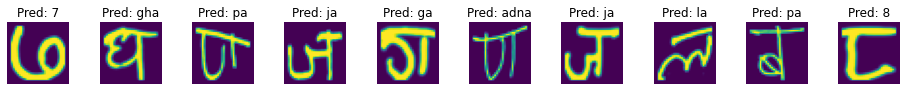

Classification report for classifier kNN-SVM:
                           precision    recall  f1-score   support

          character_01_ka       0.99      0.94      0.97       380
         character_02_kha       0.99      0.92      0.95       404
          character_03_ga       0.86      0.92      0.89       371
         character_04_gha       0.87      0.85      0.86       404
         character_05_kna       0.95      0.84      0.89       423
         character_06_cha       0.94      0.97      0.95       394
        character_07_chha       0.95      0.89      0.92       395
          character_08_ja       0.92      0.95      0.93       384
         character_09_jha       1.00      0.93      0.97       401
         character_10_yna       0.95      0.91      0.93       388
    character_11_taamatar       0.83      0.95      0.89       426
        character_12_thaa       0.95      0.88      0.91       382
         character_13_daa       0.85      0.90      0.87       421
        charact

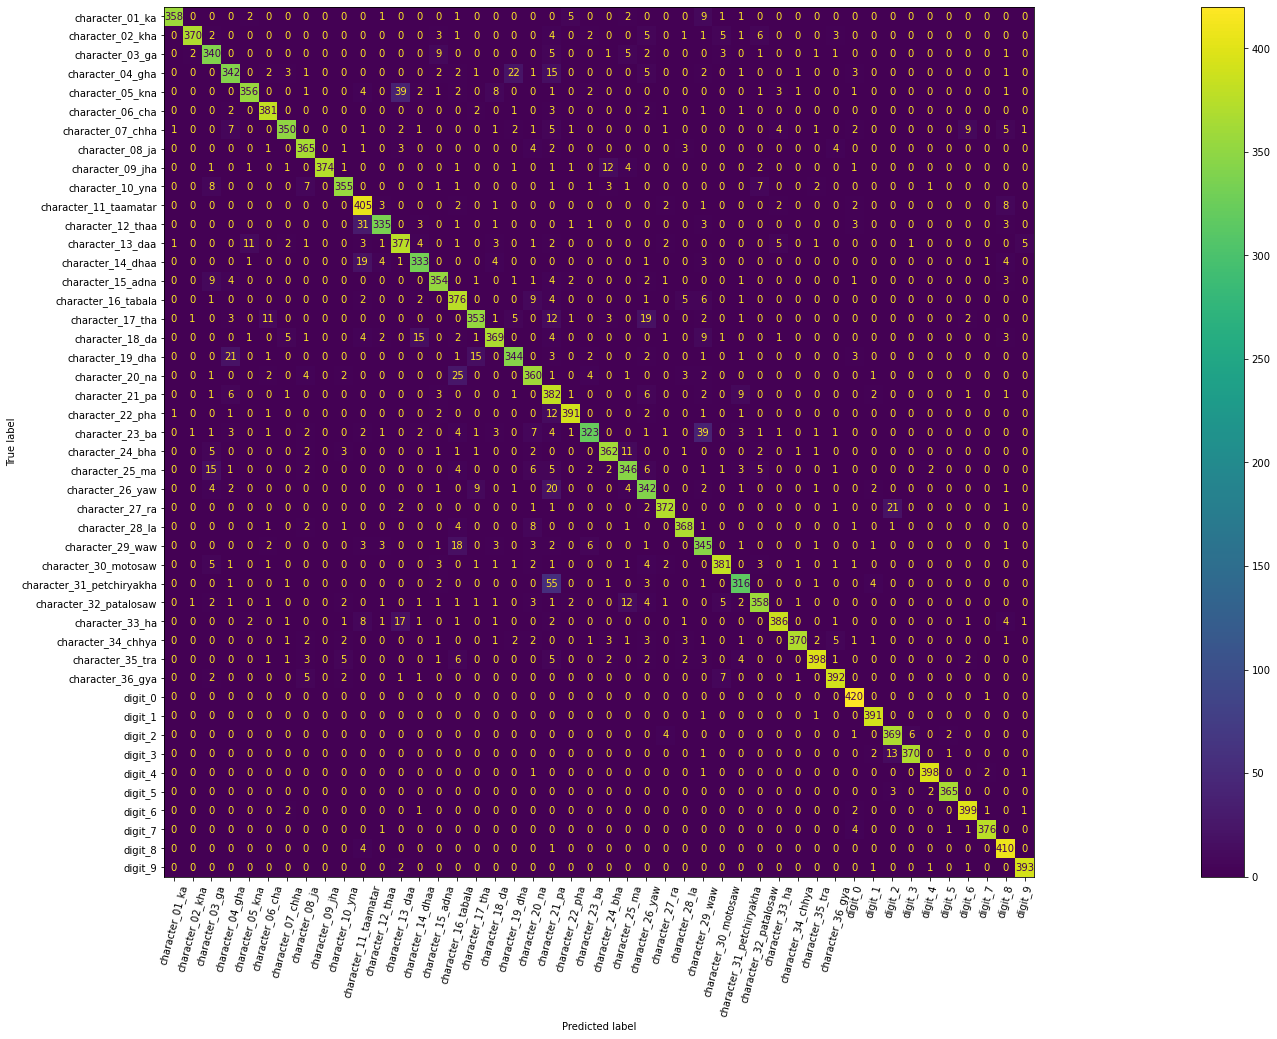

kNN prediction accuracy: 79.96
Conditional SVM prediction accuracy: 65.28


In [13]:
knn_clf = OneVsRestClassifier(neighbors.KNeighborsClassifier(n_neighbors=3), n_jobs=-1)

knn_hit = knn_miss = svm_hit = svm_miss = 0

start = time()
knn_clf.fit(Xr_train, yr_train)

mid = time()
yr_pred = [0 for i in range(18400)]

# Instead of running predict on the kNN classifier, get nearest neighbor indices for all test samples...
kneighbors = (knn_clf.estimators_[0]).kneighbors(Xr_test, return_distance=False)

# ...and use SVM to predict in case not all *training set-indexed* nearest neighbours are the same
for idx, indices in enumerate(kneighbors):
  # Find the actual training samples & their labels
  neighbors = [Xr_train[i] for i in indices]
  neighbors_labels = [yr_train.iloc[i] for i in indices]

  # Predict
  if len(set(neighbors_labels)) == 1:
    yr_pred[idx] = neighbors_labels[0]
    knn_hit += 1
#    print("For test sample %i, all_same, real char is %s and predicted char is %s" % (idx, yr_test.iloc[idx], yr_pred[idx]))
  else:
    print
    knn_miss += 1
    # Use stronger regularization than default because of the much smaller training set for this run
    svm_clf = svm.SVC(C=0.5, decision_function_shape='ovo', random_state=42)
    svm_clf.fit(neighbors, neighbors_labels)
    label = svm_clf.predict(Xr_test[idx].reshape(1, -1))

    yr_pred[idx] = label[0]
#    print("For test sample %i, SVM, real char is %s and predicted char is %s" % (idx, yr_test.iloc[idx], yr_pred[idx]))
    if yr_test.iloc[idx] == yr_pred[idx]:
        svm_hit += 1
    else:
        svm_miss += 1

end = time()

images_and_predictions = list(zip(images[yr_test.index], yr_pred))
fig, ax = plt.subplots(1, 10, figsize=(16, 16))
for axis, (image, prediction) in zip(ax[:], images_and_predictions[13000:13010]):
    axis.set_axis_off()
    axis.imshow(image)
    axis.set_title('Pred: %s' % prediction.split("_")[-1])

plt.subplots_adjust(wspace=0.5)
plt.show()

print("Classification report for classifier kNN-SVM:\n%s\n" % metrics.classification_report(yr_test, yr_pred))

cm = metrics.confusion_matrix(yr_test, yr_pred)
print("Confusion matrix:\n%s" % cm)
disp = ConfusionMatrixDisplay(cm).plot()
disp.figure_.set_size_inches(16, 16)

xtick_locs, xtick_labels = plt.xticks()
xtick_labels = list(df.iloc[:,1024].value_counts().sort_index().keys())
plt.xticks(ticks=xtick_locs, labels=xtick_labels, rotation=75)
plt.subplots_adjust(left=-2)

ytick_locs, ytick_labels = plt.yticks()
plt.yticks(ticks=ytick_locs, labels=xtick_labels)

plt.show()

lst = ['kNN-SVM']
lst.extend([0.0, 0.0, 0.0])
lst.extend([accuracy_score(yr_test, yr_pred), mid - start, end - mid])
results.append(lst)
#print(results)

print("kNN prediction accuracy: %.2f" % (knn_hit/18400*100))
if knn_miss > 0:
    print("Conditional SVM prediction accuracy: %.2f" % (svm_hit/knn_miss*100))

## Plotting and visualization

I have focused on two kinds of visualizations -

1. scatterplot of accuracy vs. overall time taken, separately for each dataset
    * Overall time taken is training time + prediction time.
2. ratio of performance metrics between the two datasets
    * The ratios have reduced-dimension dataset perf metrics as the numerator.

### Accuracy vs. total time - 1024 features

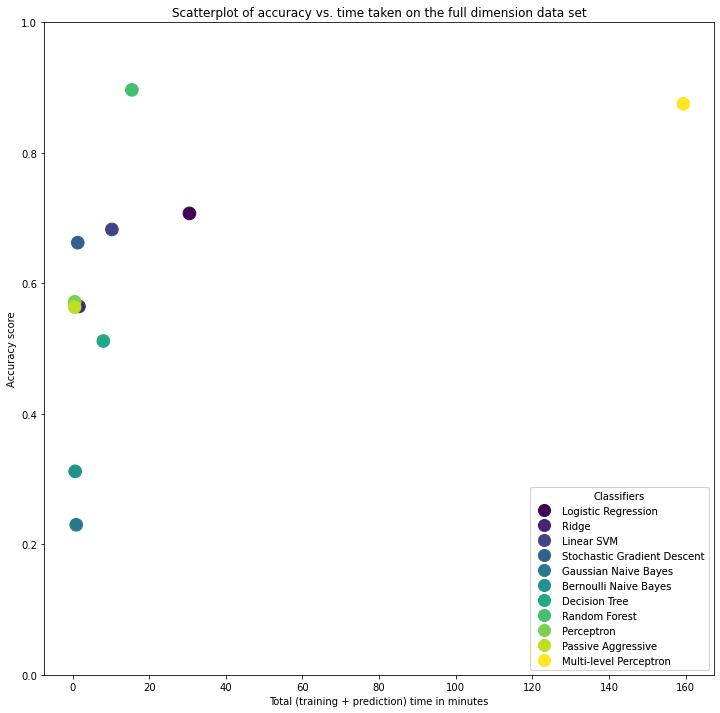

In [14]:
pre_plot_results = results
results = [[x[i] for x in results] for i in range(7)]
clf_names, full_score, full_training_time, full_test_time, reduced_score, reduced_training_time, reduced_test_time = results

full_total_time = (np.array(full_training_time) + np.array(full_test_time))/60.0

full_length = len(clf_names)
clf_names = [clf_names[i] for i in range(full_length) if full_score[i] != 0]
full_score = [full_score[i] for i in range(full_length) if full_score[i] != 0]
full_total_time = full_total_time[full_total_time > 0]

c = np.arange(len(full_score)) + 1

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()
ax.set_title("Scatterplot of accuracy vs. time taken on the full dimension data set")
scatter = ax.scatter(full_total_time, full_score, c=c, s=160)
hndls, lbls = scatter.legend_elements()
legend = ax.legend(hndls, clf_names, loc="lower right", title="Classifiers", markerscale=2)
ax.add_artist(legend)
ax.set_xlabel("Total (training + prediction) time in minutes")
ax.set_ylabel("Accuracy score")
ax.set_ybound(lower=0.0, upper=1.0)

plt.show()

### Accuracy vs. total time - 403 features

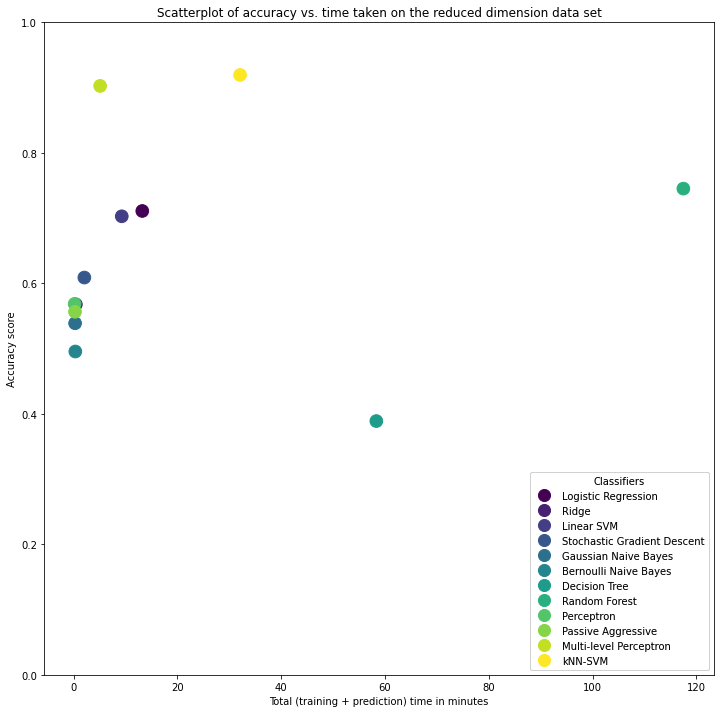

In [15]:
clf_names, full_score, full_training_time, full_test_time, reduced_score, reduced_training_time, reduced_test_time = results

reduced_total_time = (np.array(reduced_training_time) + np.array(reduced_test_time))/60.0

full_length = len(clf_names)
clf_names = [clf_names[i] for i in range(full_length) if reduced_score[i] != 0]
reduced_score = [reduced_score[i] for i in range(full_length) if reduced_score[i] != 0]
reduced_total_time = reduced_total_time[reduced_total_time > 0]

c = np.arange(len(reduced_score)) + 1

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()
ax.set_title("Scatterplot of accuracy vs. time taken on the reduced dimension data set")
scatter = ax.scatter(reduced_total_time, reduced_score, c=c, s=160)
hndls, lbls = scatter.legend_elements()
legend = ax.legend(hndls, clf_names, loc="lower right", title="Classifiers", markerscale=2)
ax.add_artist(legend)
ax.set_xlabel("Total (training + prediction) time in minutes")
ax.set_ylabel("Accuracy score")
ax.set_ybound(lower=0.0, upper=1.0)

plt.show()

### Relative performance - 403 features : 1024 features

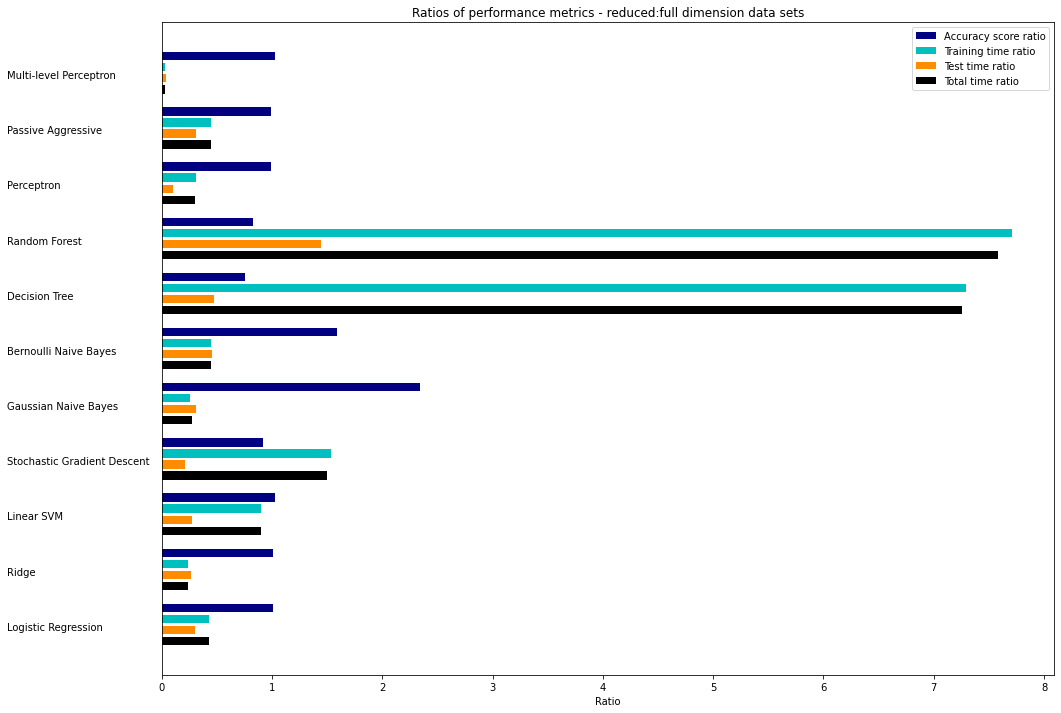

In [16]:
clf_names, full_score, full_training_time, full_test_time, reduced_score, reduced_training_time, reduced_test_time = results

full_length = len(clf_names)
filtered_indices = [i for i in range(full_length) if ((full_score[i] != 0) & (reduced_score[i] != 0))]

clf_names = [clf_names[i] for i in filtered_indices]
full_score = [full_score[i] for i in filtered_indices]
full_training_time = [full_training_time[i] for i in filtered_indices]
full_test_time = [full_test_time[i] for i in filtered_indices]
reduced_score = [reduced_score[i] for i in filtered_indices]
reduced_training_time = [reduced_training_time[i] for i in filtered_indices]
reduced_test_time = [reduced_test_time[i] for i in filtered_indices]

training_time_ratios = np.array(reduced_training_time)/np.array(full_training_time)
test_time_ratios = np.array(reduced_test_time)/np.array(full_test_time)
total_time_ratios = (np.array(reduced_training_time) + np.array(reduced_test_time)) / (np.array(full_training_time) + np.array(full_test_time))
accuracy_ratios = np.array(reduced_score)/np.array(full_score)

filtered_indices = [filtered_indices.index(i) for i in filtered_indices]

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot()
ax.set_title("Ratios of performance metrics - reduced:full dimension data sets")
plt.barh(np.array(filtered_indices) + .6, accuracy_ratios, .15, label="Accuracy score ratio", color='navy')
plt.barh(np.array(filtered_indices) + .4, training_time_ratios, .15, label="Training time ratio", color='c')
plt.barh(np.array(filtered_indices) + .2, test_time_ratios, .15, label="Test time ratio", color='darkorange')
plt.barh(filtered_indices, total_time_ratios, .15, label="Total time ratio", color='black')
plt.yticks(())
plt.legend(loc='upper right')
ax.set_xlabel("Ratio")

for i, c in zip(filtered_indices, clf_names):
    plt.text(-1.4, i + 0.2, c)

plt.show()

## Conclusion

This is a basic notebook set up to run and compare the performance of different ML classification algorithms applied to the task of recognizing handwritten Devanagari characters.

With few modifications, this notebook can be extended in any of the following ways (and more) -

* looking at other image datasets (not just alphabets, and not just Devanagari in alphabets)
* addition of more algorithms to the comparison, including pipelines and custom architectures
* addition of more workflow steps such as cross-validation
* comparison of different hyperparameter configurations and other configuration options
* a robust benchmarking library that could be invoked from the command-line or from any other program